# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias, Nidham Gazagnadou
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## <font color='red'>VERY IMPORTANT: if some of the following instructions is not followed, it will be penalized</font>

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 25th of October at 21:55**, using the **moodle platform**.
- Only **one submission by pair** of students
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [ ]:
# Change here using YOUR first and last names
fn1 = "bastien"
ln1 = "billiot"
fn2 = "simon"
ln2 = "demouchy"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_billiot_bastien_and_demouchy_simon.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[0. Test Numba](#numba)<br>
[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [ ]:
%matplotlib inline

In [ ]:
from time import time

import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
import numba # available at: http://numba.pydata.org/numba-doc/latest/user/installing.html
from numba import njit

In [ ]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='numba'></a>
## 0. Make sure Numba is correctly installed
Instructions available at: http://numba.pydata.org/numba-doc/latest/user/installing.html

In [ ]:
print(numba.__version__) # Your version of Numba

0.48.0


In [ ]:
@njit
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0
    # assuming square input matrix
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

x = np.arange(100).reshape(10, 10)
go_fast(x); # Running a first time the function to compile it

Iteration time of the Numba-compiled function.

In [ ]:
%timeit go_fast(x)

The slowest run took 21.24 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 716 ns per loop


Numba-compiled function have a special `.py_func` attribute which is the original uncompiled Python function.  Iteration time of the uncompiled function should be greater.

In [ ]:
%timeit go_fast.py_func(x)

10000 loops, best of 3: 24 µs per loop


<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [ ]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [ ]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [ ]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [ ]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [ ]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


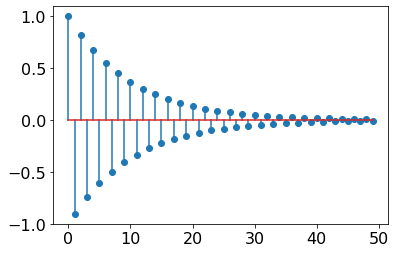

In [ ]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [ ]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.3)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

2.022824037517518e-06

In [ ]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.3)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

1.6967324345082812e-07

### Choice of the model

In [ ]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.3)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [ ]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.5273664780892771


### Get a very precise minimum to compute distances to minimum

In [ ]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.5180392078466273
3.013033732449255e-09


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD, BFGS)

### Define a class to monitor iterations

In [ ]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [ ]:
# Number of full batch iterations
n_iter = 50

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Q1) Fill in the iteration of the GD solver in the cell below

In [ ]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x -= step * grad(x, A, b, lbda)
        
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
step = 1. / lipschitz_constant(A, b, lbda) #TODO # to be set to theoretical step size
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Q2) Fill in the iteration of the AGD solver in the cell below

In [ ]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        ### TODO
        x_0 = x.copy()
        x = y - step * grad(y, A, b, lbda)
        t_0 = t
        t = 0.5 * (1 + np.sqrt(1 + 4 * t**2))
        y = x + (t_0 - 1) / t * (x - x_0)

        ### END TODO
    return x, x_list

In [ ]:
step = 1. / lipschitz_constant(A, b, lbda) # TODO
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### scipy.optimize's L-BFGS

Let's compare with ``scipy.optimize``'s L-BFGS solver

In [ ]:
class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

In [ ]:
# L-BFGS algorithm
from scipy.optimize import fmin_l_bfgs_b


x_init = np.zeros(d)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [ ]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
    

def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

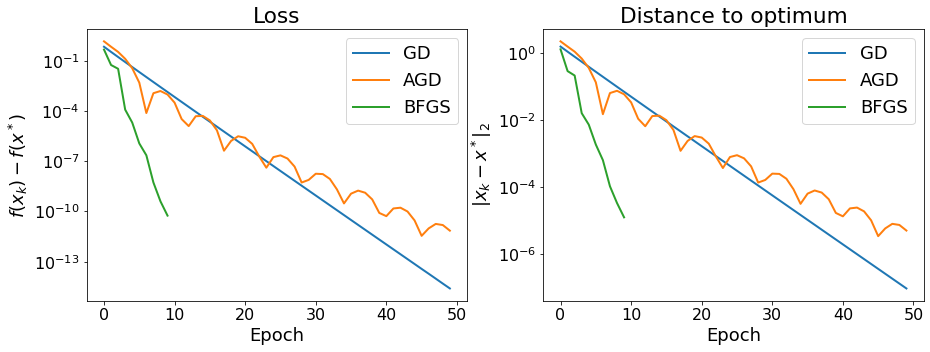

In [ ]:
monitors = [monitor_gd, monitor_agd, monitor_bfgs]

solvers = ["GD", "AGD", "BFGS"]

plot_epochs(monitors, solvers)

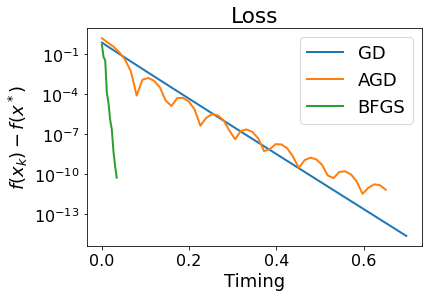

In [ ]:
plot_time(monitors, solvers)

### First conclusions

*QUESTIONS*:

- Q3.1) Give some first conclusions about the batch solver studied here
- Q3.2) What do you observe about AGD? is it suprising ?


- We can see that the L-BFGS optimizer reach a result close to the AGD method both for the distance to the optimum point and argument. However the L-BFGS optiizer is more efficient as these results are obtained faster, using less epochs. Moreover, the method which appears to be the most efficient is GD as both $f(x_k) - f(x^*)$ and $\|x_k - x^*\|_2$ are smaller using this method compared to the two other ones. However, the L-BFGS remains faster than GD.  
- AGD seems to perorm well until the 20th epoch but then the loss and distance to the minimum reduces surprisingly less than the GD method. 

<a id='stoc'></a> 
## 4. Stochastic methods

*QUESTIONS*:

- Q4) What is the link between ``n_iter`` argument for GD and ``n_iter`` argument for stochastic methods (SGD, SAGA, SVRG)? In other words, why did we introduce ``n_epoch`` for stochastic methods?


- The difference between the full or deterministic gradient descent methods and the stochastic ones is that deterministic methods use the computation over each data points before summing them to compute the gradient and one update the parameter. 
- Therefore, ``n_iter`` corresponds for GD to the number of parameter updates we compute and for each update, the gradient of each data point is computed before they are summed up to update. ``n_iter`` is the number of full batch iterations, each iteration computing ``n``gradients. 
- On the other hand, the parameter update in stochastic methods use the computation of one data point's gradient selected randomly. Thus for stochastic methods ``n_iter`` corresponds as well to the number of parameter update but not the number of full batch iterations as during one iteration (or parameter update) only one data point selected randomly is chosen. Thus we introduce ``n_epoch`` which corresponds to the number of iterations in stochastics methods (just as in GD) but also enables to retrieve the number of points' gradients computed in GD ``n*n_epoch``. 

In [ ]:
n_epoch = 50 # number of epochs

# generate indices of random samples
iis = np.random.randint(0, n, 
                        #TODO
                       n * n_epoch) # to have the same number of epochs as for GD

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Q5) Fill in the iteration of the SGD solver in the cell below

In [ ]:
@njit
def sgd(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    t = 0.
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        x -= (step / np.sqrt(t + 1)) * grad_i(i, x, A, b, lbda)
        t += 1
        ### END TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, iis, grad_i, 
                #TODO
                n * n_epoch, 
                step0, args=(A, b, lbda)) # same as in the cell after Q4

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Q6) Fill in the iteration of the SAG solver in the cell below

In [ ]:
#@njit
def sag(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO

        gradient_memory[i] = grad_i(i, x, A, b, lbda)
        
        averaged_gradient = np.mean(gradient_memory,axis = 0)
        
        x -= step * averaged_gradient

        ### END OF TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)
x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, iis, grad_i, 
                n * n_epoch, 
                step, args=(A, b, lbda)) # same as in the cell after Q4

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Q7) Fill in the iteration of the SVRG solver in the cell below

In [ ]:
@njit
def svrg(x_init, iis, grad, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    for idx in range(n_iter):
        
        ### TODO
        i = iis[idx]

        if idx % n == 0:

          x_old = x.copy()
          mu  = grad(x_old, A, b, lbda)

        x -= step * (grad_i(i, x, A, b, lbda) - grad_i(i, x_old, A, b, lbda) + mu)
        ### END TODO        
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, iis, grad, grad_i, 
                 #TODO
                 n*n_epoch,
                 step, args=(A, b, lbda)) # same as in the cell after Q4

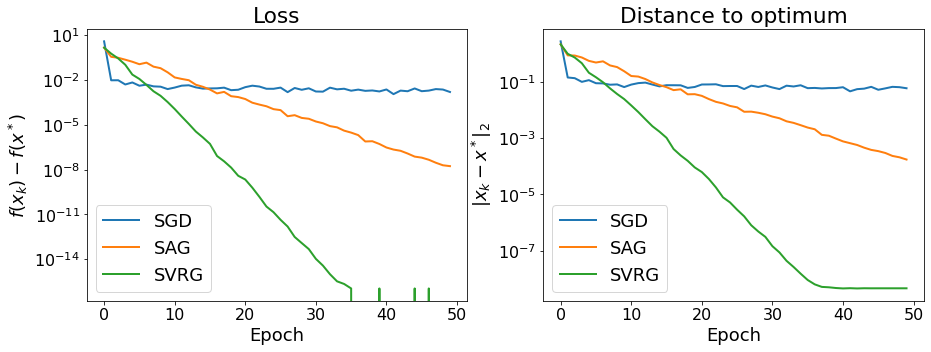

In [ ]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

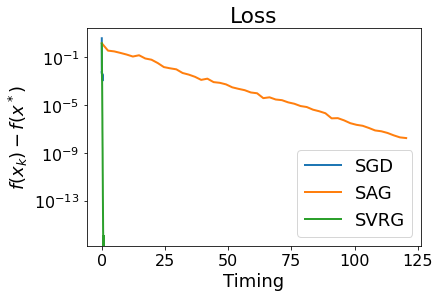

In [ ]:
plot_time(monitors, solvers)

### First conclusions

*QUESTIONS*:

- Q8) Compare the converge (on the different plots) of the stochastic methods you implemented

SAG and SVRG converge faster than SGD which is better at the beginning but then doest not manage to improve its convergence as we saw in course. Also, we observe that SVRG is faster than SAG with a better convergence (lower scores for $f(x_k) - f(x^*)$ and $\|x_k - x^*\|_2$)

<a id='comp'></a> 
## 5. Numerical comparison

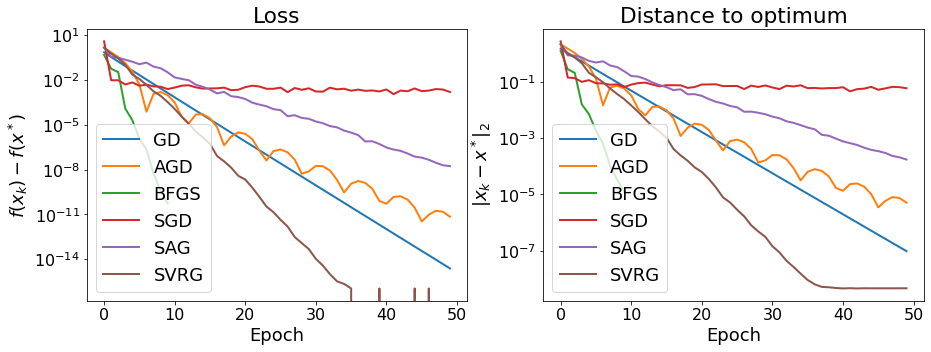

In [ ]:
monitors = [monitor_gd, monitor_agd, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "BFGS", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

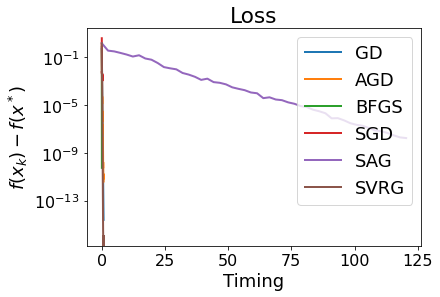

In [ ]:
plot_time(monitors, solvers)

<a id='conc'></a>
## 6. Conclusion

__For these questions, only plot relevant examples (do not plot hundreds of figures) and give SHORT answers showing your understanding of the different behaviours.__

*QUESTIONS*:

For all the following questions, try to show only **FEW INFORMATIVE FIGURES** that highlight your conclusions.
- Q9) Compare the deterministic and the stochastic gradient methods. Comment your results.
- Q10) Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Q11) Look carefuly on how the data are generated in functions  ``simu_linreg`` and ``simu_logreg``. Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.

For next questions, work **only on logistic regression**
- Q12) Change the number of data points $n$ and the number of data samples $d$ and compare your results. Comment.
- Q13) Conclude on the performance on the implemented methods. Are their "regimes" for which some methods are faster than others?
- Q14) Are there different behaviours between the deterministic methods? What about the stochastic ones?
- Q15) Compare the memory, the number of hyper-parameters to tune and the ease of implementation of each algorithm. According to this, in which configuration do you think a user should use deterministic method rather than a stochastic one, and vice-versa?

Question 9 : Compare the deterministic and the stochastic gradient methods. Comment your results.

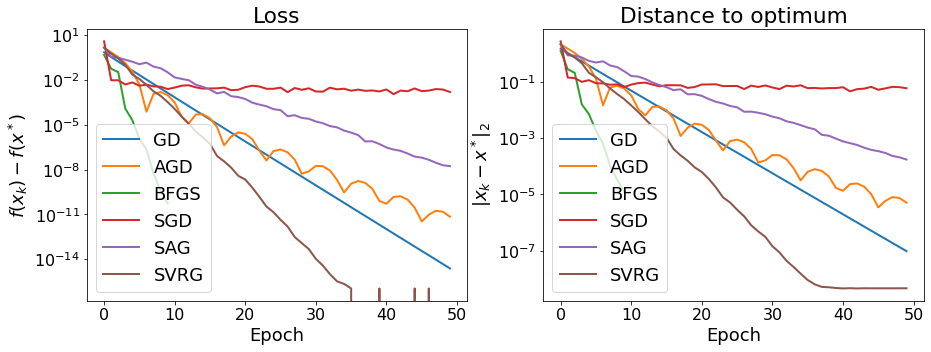

In [ ]:
monitors = [monitor_gd, monitor_agd, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "BFGS", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

There are difference among determistic and stochastic gradient methods, therefore we can not conclude than a method is better than another. However, we can remark than among all these methods, BFGS seems to be the best method.

Question 10 : Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.

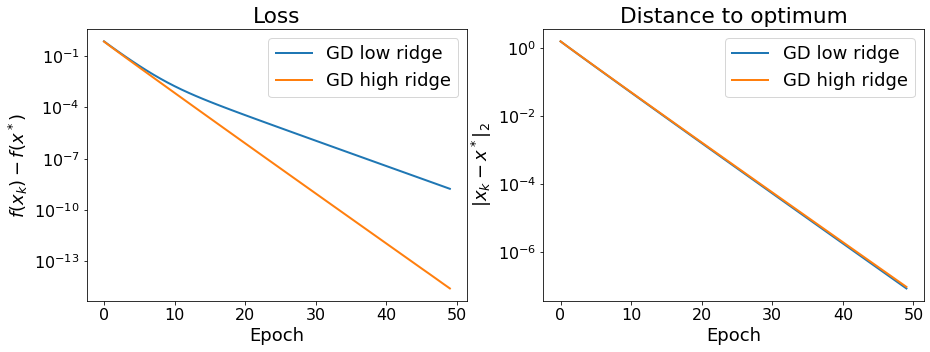

In [ ]:
step = 1. / lipschitz_constant(A, b, 1/n) 
x_init = np.zeros(d)
monitor_gd_low_ridge = monitor(gd, loss, x_min, (A, b ,1/n))
monitor_gd_low_ridge.run(x_init, grad, n_iter, step, args=(A, b, 1/n))
  
x_init = np.zeros(d)
step = 1. / lipschitz_constant(A, b, 1/np.sqrt(n)) 
monitor_gd_high_ridge = monitor(gd, loss, x_min, (A, b ,1/np.sqrt(n)))
monitor_gd_high_ridge.run(x_init, grad, n_iter, step, args=(A, b, 1/np.sqrt(n)))

monitors = [monitor_gd_low_ridge,monitor_gd_high_ridge]

solvers = ["GD low ridge", "GD high ridge"]

plot_epochs(monitors, solvers)

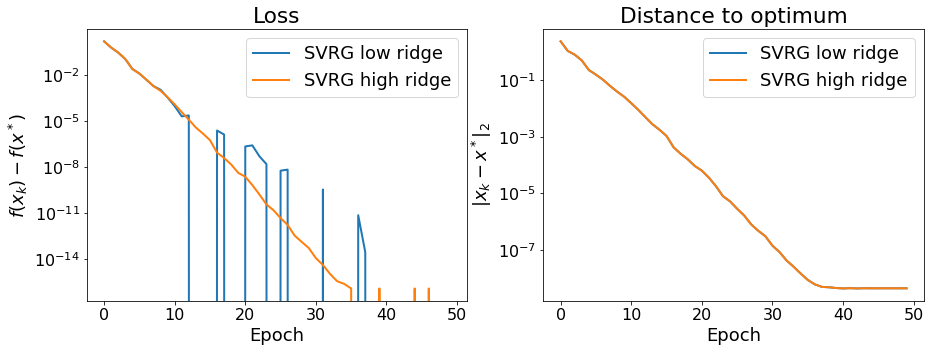

In [ ]:
step = 1.0 / (max_squared_sum + 1/n)
x_init = np.zeros(d)
monitor_svrg_low_ridge = monitor(svrg, loss, x_min, (A, b ,1/n))
monitor_svrg_low_ridge.run(x_init, iis,grad, grad_i, 
                n * n_epoch, 
                step, args=(A, b, 1/n))

step = 1.0 / (max_squared_sum + 1/np.sqrt(n))
x_init = np.zeros(d)
monitor_svrg_high_ridge = monitor(svrg, loss, x_min, (A, b ,1/np.sqrt(n)))
monitor_svrg_high_ridge.run(x_init, iis,grad, grad_i, 
                n * n_epoch, 
                step, args=(A, b, 1/np.sqrt(n)))

monitors = [monitor_svrg_low_ridge,monitor_svrg_high_ridge]

solvers = ["SVRG low ridge", "SVRG high ridge"]

plot_epochs(monitors, solvers)

- We can see that the GD method is less sensible to a change of the ridge regularization even though it still has an impact. Indeed, the distance to optimum remains the same with high or low ridge regularization. However, the method is much more efficient with a higher regularization concerning the loss with a better convergence. 
- However SVRG has trouble dealing with low ridge regularization.

Question 11 : Look carefuly on how the data are generated in functions  ``simu_linreg`` and ``simu_logreg``. Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.

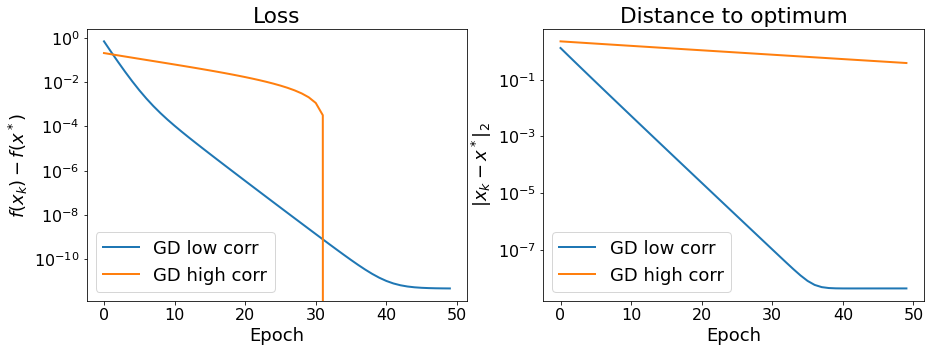

In [ ]:
A_low_corr, b_low_corr = simu_linreg(x_model_truth, n, std=1., corr=0.1)
A_high_corr, b_high_corr = simu_linreg(x_model_truth, n, std=1., corr=0.9)
step_low = 1. / lipschitz_constant(A_low_corr, b_low_corr, lbda) 

monitor_gd_low_corr = monitor(gd, loss, x_min, (A_low_corr, b_low_corr ,lbda))
monitor_gd_low_corr.run(x_init, grad, n_iter, step_low, args=(A_low_corr, b_low_corr, lbda))
  
step_high = 1. / lipschitz_constant(A_high_corr, b_high_corr, lbda) 
monitor_gd_high_corr = monitor(gd, loss, x_min, (A_high_corr, b_high_corr ,lbda))
monitor_gd_high_corr.run(x_init, grad, n_iter, step_high, args=(A_high_corr, b_high_corr, lbda))

monitors = [monitor_gd_low_corr,monitor_gd_high_corr]

solvers = ["GD low corr", "GD high corr"]

plot_epochs(monitors, solvers)

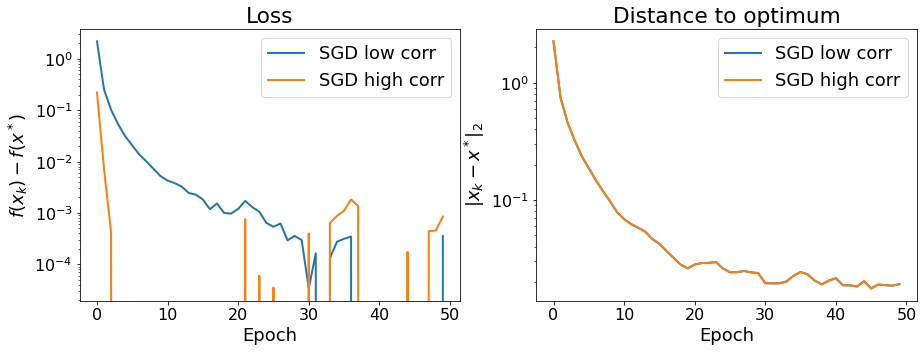

In [ ]:
A_low_corr, b_low_corr = simu_linreg(x_model_truth, n, std=1., corr=0.1)
A_high_corr, b_high_corr = simu_linreg(x_model_truth, n, std=1., corr=0.9)

monitor_sgd_low_corr = monitor(sgd, loss, x_min, (A_low_corr, b_low_corr ,lbda))
monitor_sgd_low_corr.run(x_init, iis, grad_i, 
                n * n_epoch, 
                step, args=(A_low_corr, b_low_corr, lbda))
monitor_sgd_high_corr = monitor(sgd, loss, x_min, (A_high_corr, b_high_corr, lbda))
monitor_sgd_high_corr.run(x_init, iis, grad_i, 
                n * n_epoch, 
                step, args=(A_high_corr, b_high_corr, lbda))

monitors = [monitor_sgd_low_corr,monitor_sgd_high_corr]

solvers = ["SGD low corr", "SGD high corr"]

plot_epochs(monitors, solvers)

- A higher correlation leads to better convergence whichis not surprising as with high correlation, the model will miss less information because of the regularization as the information of the penalized feature will be more present in the kept ones with high correlation

Question 12 : Change the number of data points $n$ and the number of data samples $d$ and compare your results. Comment.

In [ ]:
d = 50
n = 500
idx = np.arange(d)
x_model_truth = (-1)**idx * np.exp(-idx / 10.)
A, b = simu_logreg(x_model_truth, n, std=1., corr=0.3)
loss = loss_logreg
grad = grad_logreg
grad_i = grad_i_logreg
lipschitz_constant = lipschitz_logreg
lbda = 1. / n ** (0.5)

In [ ]:
x_init = np.zeros(d)
step0 = 1e-1
step = 1. / lipschitz_constant(A, b, lbda)

monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, iis, grad_i, 
                n * n_epoch, 
                step0, args=(A, b, lbda))
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, iis, grad_i, 
                n * n_epoch, 
                step, args=(A, b, lbda)) 
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, iis, grad, grad_i, 
                 n*n_epoch,
                 step, args=(A, b, lbda))

monitors = [monitor_gd, monitor_agd, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "BFGS", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

ValueError: ignored

Question 13 : Conclude on the performance on the implemented methods. Are their "regimes" for which some methods are faster than others?

Question 14 : Are there different behaviours between the deterministic methods? What about the stochastic ones?

Question 15 : Compare the memory, the number of hyper-parameters to tune and the ease of implementation of each algorithm. According to this, in which configuration do you think a user should use deterministic method rather than a stochastic one, and vice-versa?